# Winning Jeopardy

Jeopardy is a popular TV show in the US where participants answer questions to win money. It's been running for many years, and is a major force in popular culture. If you need help at any point, you can consult our solution notebook [here](https://github.com/dataquestio/solutions/blob/master/Mission210Solution.ipynb).

In this project, I'll work with a dataset of Jeopardy questions to figure out some patterns in the questions that could help you win.

The dataset is named *jeopardy.csv*, and contains `20000` rows from the beginning of a full dataset of Jeopardy questions.

In [107]:
## packages 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import re
from random import sample
from scipy.stats import chisquare
%matplotlib inline

In [16]:
## functions
def normalize_text(string):
    string = string.lower()
    string = re.sub("[^A-Za-z0-9\s]", "", string)
    string = re.sub("\s+", " ", string)
    return string

def normalize_values(value):
    value = re.sub("[^A-Za-z0-9\s]", "", value)
    try:
        value = int(value)
    except Exception:
        value = 0
    return value


In [2]:
jeopardy_df = pd.read_csv('jeopardy.csv')

In [3]:
jeopardy_df.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


As you can see, each row in the dataset represents a single question on a single episode of Jeopardy. Here are explanations of each column:

- `Show Number` - the Jeopardy episode number
- `Air Date` - the date the episode aired
- `Round` - the round of Jeopardy
- `Category` - the category of the question
- `Value` - the number of dollars the correct answer is worth
- `Question` - the text of the question
- `Answer` - the text of the answer

In [5]:
jeopardy_df.columns

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')

In [7]:
# some columns names habe spaces, so lets remove then
jeopardy_df.columns = ['Show Number', 'Air Date', 'Round', 'Category', 'Value','Question', 'Answer']

In [14]:
## normalize string columns 
jeopardy_df['clean_question'] = jeopardy_df['Question'].apply(normalize_text)

jeopardy_df['clean_answer'] = jeopardy_df['Answer'].apply(normalize_text)

In [17]:
## normalize number values
jeopardy_df['clean_value'] = jeopardy_df['Value'].apply(normalize_values)

In [18]:
jeopardy_df['Air Date'] = pd.to_datetime(jeopardy_df['Air Date'])

In [19]:
## dataset after transformations
jeopardy_df.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer,clean_question,clean_answer,clean_value
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus,for the last 8 years of his life galileo was u...,copernicus,200
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,no 2 1912 olympian football star at carlisle i...,jim thorpe,200
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona,the city of yuma in this state has a record av...,arizona,200
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,in 1963 live on the art linkletter show this c...,mcdonalds,200
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,signer of the dec of indep framer of the const...,john adams,200


In [20]:
jeopardy_df.dtypes

Show Number                int64
Air Date          datetime64[ns]
Round                     object
Category                  object
Value                     object
Question                  object
Answer                    object
clean_question            object
clean_answer              object
clean_value                int64
dtype: object

### Answers in Questions
In order to figure out whether to study past questions, study general knowledge, or not study it all, it would be helpful to figure out two things:

- How often the answer can be used for a question.
- How often questions are repeated.

In [27]:
def count_matches(row):
    split_answer = row['clean_answer'].split()
    split_question = row['clean_question'].split()
    match_count = 0 
    
    if 'the' in split_answer: 
        split_answer.remove('the')

    if len(split_answer) == 0:
        return 0 
    
    for val in split_answer: 
        if val in split_question:
            match_count += 1
    
    return match_count/len(split_answer)

In [28]:
jeopardy_df["answer_in_question"] = jeopardy_df.apply(count_matches, axis=1)

In [57]:
jeopardy_df["answer_in_question"].mean()

0.05900196524977763

On average 5.9% of the answer words appearing in question. I think this is to low to be useful. But I will try to get more info with a plot tht shows the percentage.

In [65]:
hist_data = jeopardy_df["answer_in_question"].value_counts(normalize = True, bins=5)*100
hist_data.sort_index(inplace = True)
hist_data

(-0.002, 0.2]    88.024401
(0.2, 0.4]        3.425171
(0.4, 0.6]        7.310366
(0.6, 0.8]        0.615031
(0.8, 1.0]        0.625031
Name: answer_in_question, dtype: float64

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

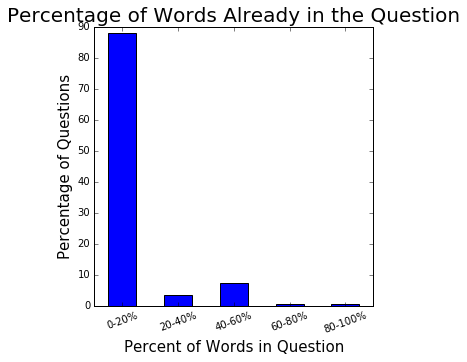

In [66]:
#Plotting histogram
fig = plt.figure(figsize = (5,5))

ax = fig.add_subplot(1,1,1)

#Setting limits and ticks
ax.set_xticks([0, 1.0, 2.0, 3.0, 4.0, 5.0])
ax.set_xlim(0,5)
ax.set_ylim(0,90)

#Title
ax.set_title('Percentage of Words Already in the Question', size = 20)

#Plotting
hist_data.plot.bar(color = 'blue')

#Adding axes labels
ax.set_xlabel('Percent of Words in Question',fontsize = 15)
ax.set_ylabel('Percentage of Questions', fontsize = 15)

#Adding better xticks labels
ax.set_xticklabels(['0-20%','20-40%','40-60%','60-80%','80-100%'])

#Rotating the xticks labels for readability
plt.xticks(rotation = 20)

The graph shows that the majority of the answers don't have, or have few, words in the question. 

## Recycled Questions
Now I want to investigate how often new questions are repeats of older ones. I can't completely answer this, because you only have about 10% of the full Jeopardy question dataset, but you can investigate it at least.

In [73]:
question_overlap = []
terms_used = set()
jeopardy_df = jeopardy_df.sort_values('Air Date')

In [75]:
question_overlap = []
terms_used = set()

jeopardy_df = jeopardy_df.sort_values("Air Date")

for i, row in jeopardy_df.iterrows():
        split_question = row["clean_question"].split(" ")
        split_question = [q for q in split_question if len(q) > 5]
        match_count = 0
        for word in split_question:
            if word in terms_used:
                match_count += 1
        for word in split_question:
            terms_used.add(word)
        if len(split_question) > 0:
            match_count /= len(split_question)
        question_overlap.append(match_count)
jeopardy_df["question_overlap"] = question_overlap

jeopardy_df["question_overlap"].mean()

0.6877843800700857

There is about 70% overlap between terms in new questions and terms in old questions. This only looks at a small set of questions, and it doesn't look at phrases, it looks at single terms. This makes it relatively insignificant, but it does mean that it's worth looking more into the recycling of questions.

In [76]:
histo = jeopardy_df['question_overlap'].value_counts(normalize = True
                                          ,bins = 10)*100
histo.sort_index(inplace = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

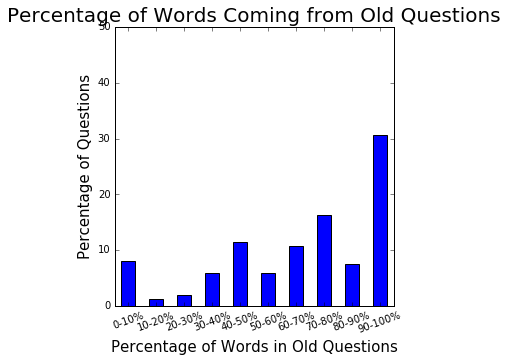

In [77]:
#Creating figure and plot
fig = plt.figure(figsize = (5,5))

ax = fig.add_subplot(1,1,1)

#Setting limits and ticks
ax.set_xticks([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
ax.set_xlim(0,5)
ax.set_ylim(0,50)

#Title
ax.set_title('Percentage of Words Coming from Old Questions', size = 20)

#Plotting
histo.plot.bar(color = 'blue')

#Adding axes labels
ax.set_xlabel('Percentage of Words in Old Questions',fontsize = 15)
ax.set_ylabel('Percentage of Questions', fontsize = 15)

#Adding xticks labels
ax.set_xticklabels(['0-10%','10-20%','20-30%','30-40%','40-50%'
                    ,'50-60%','60-70%','70-80%','80-90%','90-100%'])

#Rotating the xticks labels for readability
plt.xticks(rotation = 20)

It seems 30% of the questions have more than 90 percent of their words consisting of previously used terms. Another large portion has a least half of their words consisting of previously used terms.

This indicates that studying past questions might be a good idea.

## Low Value vs High Value Questions
Now I only want to study questions that pertain to high value questions instead of low value questions. This will help you earn more money when you're on Jeopardy.

I'll figure out which terms correspond to high-value questions using a chi-squared test. You'll first need to narrow down the questions into two categories:

- Low value -- Any row where `Value` is less than `800`.
- High value -- Any row where `Value` is greater than `800`.

I'll then be able to loop through each of the terms from the last screen, `terms_used`, and:

- Find the number of low value questions the word occurs in.
- Find the number of high value questions the word occurs in.
- Find the percentage of questions the word occurs in.
- Based on the percentage of questions the word occurs in, find expected counts.
- Compute the chi squared value based on the expected counts and the observed counts for high and low value questions.

I can then find the words with the biggest differences in usage between high and low value questions, by selecting the words with the highest associated chi-squared values. Doing this for all of the words would take a very long time, so we'll just do it for a small sample now.

In [80]:
def set_value(row):
    value = 0
    if row['clean_value'] > 800:
        value = 1
    return value

jeopardy_df['high_value'] = jeopardy_df.apply(set_value, axis=1)

In [87]:
def word_count(word):
    low_count = 0 
    high_count = 0
    for i, row in jeopardy_df.iterrows():
        if word in row['clean_question'].split(" "):
            if row['high_value'] == 1:
                high_count +=1
            else:
                low_count += 1
    return high_count, low_count


In [89]:
word_count('english')

(37, 57)

In [113]:
comparison_terms= sample(terms_used,10)
observed_expected = []

for term in comparison_terms: 
    observed_expected.append(word_count(term))
    
observed_expected    

[(0, 1),
 (0, 2),
 (0, 1),
 (0, 1),
 (0, 4),
 (1, 0),
 (1, 0),
 (0, 1),
 (0, 1),
 (1, 0)]

## Applying the Chi-squared Test

In [116]:
high_value_count = jeopardy_df[jeopardy_df['high_value']==1].shape[0]
low_value_count = jeopardy_df[jeopardy_df['high_value']==0].shape[0]

chi_squared = []
i = 0
for pair in observed_expected:
    total = sum(pair)
    total_prop = total / jeopardy_df.shape[0]
    high_value_exp = total_prop * high_value_count
    low_value_exp = total_prop * low_value_count
    
    observed = np.array([pair[0], pair[1]])
    expected = np.array([high_value_exp, low_value_exp])
    chi_squared.append(chisquare(observed, expected))
    
chi_squared

[Power_divergenceResult(statistic=0.401962846126884, pvalue=0.5260772985705469),
 Power_divergenceResult(statistic=0.803925692253768, pvalue=0.3699222378079571),
 Power_divergenceResult(statistic=0.401962846126884, pvalue=0.5260772985705469),
 Power_divergenceResult(statistic=0.401962846126884, pvalue=0.5260772985705469),
 Power_divergenceResult(statistic=1.607851384507536, pvalue=0.20479409439225948),
 Power_divergenceResult(statistic=2.487792117195675, pvalue=0.11473257634454047),
 Power_divergenceResult(statistic=2.487792117195675, pvalue=0.11473257634454047),
 Power_divergenceResult(statistic=0.401962846126884, pvalue=0.5260772985705469),
 Power_divergenceResult(statistic=0.401962846126884, pvalue=0.5260772985705469),
 Power_divergenceResult(statistic=2.487792117195675, pvalue=0.11473257634454047)]

None of the terms had a significant difference in usage between high value and low value rows. Additionally, the frequencies were all lower than 5, so the chi-squared test isn't as valid. It would be better to run this test with only terms that have higher frequencies.